# Advanced Transfer Learning with ResNet18 on CIFAR-10

This notebook demonstrates advanced transfer learning using a pretrained ResNet18 model on the CIFAR-10 dataset. We'll replace the classifier head and fine-tune the model for better performance.

## 1. Import Required Libraries

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import time
from sklearn.model_selection import train_test_split

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 2. Load and Preprocess CIFAR-10 Dataset + Data Augmentation

CIFAR-10 consists of 60,000 32x32 color images in 10 classes. We'll apply extensive data augmentation including random cropping, flipping, rotation, color jittering, affine transformations, perspective distortion, and random erasing to improve model generalization and robustness.

In [35]:
# Data transforms for training and validation with enhanced augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),  # First resize to larger size 256x256 (because now we can crop out image)
        transforms.RandomCrop(224),  # Random crop to 224x224
        transforms.RandomHorizontalFlip(),  # Horizontal flip
        transforms.RandomVerticalFlip(p=0.1),  # Occasional vertical flip
        transforms.RandomRotation(15),  # Random rotation up to 15 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color adjustments
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Translation and scaling
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Perspective distortion
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3))  # Random erasing (cutout)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),  # Resize smaller images to 256x256 to prepare for center cropping
        transforms.CenterCrop(224),  # Crop the center 224x224 region to match ResNet input size
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load CIFAR-10 dataset
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms['train'])
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms['val'])

# For Stratified K-Fold tuning, keep full_train_dataset
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Full training dataset size: {len(full_train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Classes: {class_names}")

Full training dataset size: 50000
Test dataset size: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 3. Load Pretrained ResNet18 Model

We'll load the pretrained ResNet18 model from torchvision. Since CIFAR-10 images are 32x32 and ResNet expects 224x224, we've already resized them in the transforms.

In [36]:
# Load pretrained ResNet18 model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Print model architecture
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 4. Set Up Training Components

Define the loss function, optimizer, and move the model to the appropriate device.

In [37]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=20, patience=5):
    start = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_running_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)

        val_acc = val_running_corrects.double() / len(val_loader.dataset)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f}')

        # Check for improvement
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Early stopping
        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
        
    time_elapsed = time.time() - start
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

## 5. Random Search Hyperparameter Tuning for Custom Classifier

We'll perform **random search** hyperparameter tuning to find the optimal classifier architecture. Random search is more efficient than grid search and often finds better hyperparameters by exploring the search space more effectively.

**Random search advantages:**
- Tests 10 random combinations instead of all possible combinations (much faster)
- More likely to find good hyperparameters in high-dimensional spaces
- Can explore continuous ranges more effectively

Each trial uses **early stopping with patience=3** and **GPU acceleration** for maximum efficiency.

In [38]:
# Random search hyperparameter tuning for the custom classifier with early stopping

def create_classifier(num_ftrs, hidden_dims, dropout_rates, device):
    
    layers = []
    in_features = num_ftrs

    for i, out_features in enumerate(hidden_dims):
        layers.append(nn.Linear(in_features, out_features).to(device))
        layers.append(nn.ReLU())
        if i < len(dropout_rates):
            layers.append(nn.Dropout(dropout_rates[i]))
        in_features = out_features

    layers.append(nn.Linear(in_features, 10).to(device))  # 10 classes for CIFAR-10
    return nn.Sequential(*layers)

def tune_classifier_hyperparameters(model, full_train_dataset, num_trials=10, max_epochs=5):
  

    num_ftrs = model.fc.in_features

    # Define hyperparameter search spaces for random sampling
    hidden_dims_options = [
        [512, 256],        # 2 hidden layers medium
        [1024, 512, 256],  # 3 hidden layers large
        [256, 128],        # 2 hidden layers small

    ]

    dropout_options = [
        [0.3, 0.2],        # Lower dropout
        [0.5, 0.3],        # Medium dropout
    
        [0.3, 0.2, 0.1],   # For 3-layer networks
        
    ]

    lr_options = [1e-4, 1e-3]  # learning rate options
    weight_decay_options = [0,1e-4,1e-3]  # weight decay options

    best_accuracy = 0.0
    best_params = {}
    best_model_state = None

    # Get labels for stratification
    labels = [label for _, label in full_train_dataset]

    print(f"Starting random search with {num_trials} trials using 80-20 train-validation split...")

    for trial in range(num_trials):
        # Randomly sample hyperparameters
        hidden_dims = random.choice(hidden_dims_options)

        # Find compatible dropout options (same length as hidden_dims)
        compatible_dropouts = [d for d in dropout_options if len(d) == len(hidden_dims)]
        if not compatible_dropouts:
            # Fallback to generate compatible dropout
            dropout_rates = [np.random.uniform(0.1, 0.5) for _ in hidden_dims]
        else:
            dropout_rates = random.choice(compatible_dropouts)

        lr = random.choice(lr_options)
        wd = random.choice(weight_decay_options)

        print(f"\nTrial {trial+1}/{num_trials}")
        print(f"Hidden dims: {hidden_dims}, Dropout: {dropout_rates}, LR: {lr}, WD: {wd}")

        # 80-20 train-validation split
        train_idx, val_idx = train_test_split(np.arange(len(full_train_dataset)), test_size=0.2, stratify=labels, random_state=42)

        # Create subsets for this split
        train_subset = Subset(full_train_dataset, train_idx)
        val_subset = Subset(full_train_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=4)

        # Create model for this trial
        temp_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).to(device)
        temp_model.fc = create_classifier(num_ftrs, hidden_dims, dropout_rates, device)

        # Freeze all layers except classifier
        for param in temp_model.parameters():
            param.requires_grad = False
        for param in temp_model.fc.parameters():
            param.requires_grad = True

        # Setup optimizer and scheduler
        optimizer = optim.AdamW(temp_model.fc.parameters(), lr=lr, weight_decay=wd)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        # Training with early stopping for this trial
        temp_model, best_acc = train_model(temp_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=max_epochs, patience=3)

        # Use the best validation accuracy for this trial
        trial_accuracy = best_acc * 100  # Convert to percentage
        print(f"Validation Accuracy: {trial_accuracy:.2f}%")

        if trial_accuracy > best_accuracy:
            best_accuracy = trial_accuracy
            best_params = {
                'hidden_dims': hidden_dims,
                'dropout_rates': dropout_rates,
                'lr': lr,
                'weight_decay': wd
            }
            # Save the model state
            best_model_state = temp_model.state_dict().copy()

    print(f"\nBest hyperparameters found:")
    print(f"Hidden dimensions: {best_params['hidden_dims']}")
    print(f"Dropout rates: {best_params['dropout_rates']}")
    print(f"Learning rate: {best_params['lr']}")
    print(f"Weight decay: {best_params['weight_decay']}")
    print(f"Best validation accuracy: {best_accuracy:.2f}%")

    return best_params, best_accuracy, best_model_state

# Perform hyperparameter tuning with random search using 80-20 train-validation split
print("Starting random search hyperparameter tuning for the classifier...")

best_params, best_accuracy, best_model_state = tune_classifier_hyperparameters(
    models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1), full_train_dataset, num_trials=10, max_epochs=5
)

# Create the final model with best hyperparameters
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = create_classifier(num_ftrs, best_params['hidden_dims'], best_params['dropout_rates'], device)
model.load_state_dict(best_model_state)
model = model.to(device)

print(f"\nFinal model architecture: {model.fc}")

Starting random search hyperparameter tuning for the classifier...
Starting random search with 10 trials using 80-20 train-validation split...

Trial 1/10
Hidden dims: [256, 128], Dropout: [0.5, 0.3], LR: 0.0001, WD: 0.0001
Epoch 0/4
----------
Train Loss: 2.1173 Acc: 0.2408 | Val Acc: 0.4291
Epoch 1/4
----------
Train Loss: 1.8111 Acc: 0.3874 | Val Acc: 0.4926
Epoch 2/4
----------
Train Loss: 1.7149 Acc: 0.4390 | Val Acc: 0.5050
Epoch 3/4
----------
Train Loss: 1.6814 Acc: 0.4579 | Val Acc: 0.5247
Epoch 4/4
----------
Train Loss: 1.6705 Acc: 0.4656 | Val Acc: 0.5142
Training complete in 2m 40s
Best val Acc: 0.5247
Validation Accuracy: 52.47%

Trial 2/10
Hidden dims: [512, 256], Dropout: [0.3, 0.2], LR: 0.0001, WD: 0.001
Epoch 0/4
----------
Train Loss: 1.9123 Acc: 0.3605 | Val Acc: 0.5021
Epoch 1/4
----------
Train Loss: 1.6204 Acc: 0.4940 | Val Acc: 0.5372
Epoch 2/4
----------
Train Loss: 1.5713 Acc: 0.5170 | Val Acc: 0.5422
Epoch 3/4
----------
Train Loss: 1.5468 Acc: 0.5283 | Val A

In [39]:
# Split full_train_dataset into train and validation
labels = [label for _, label in full_train_dataset]
train_idx, val_idx = train_test_split(np.arange(len(full_train_dataset)), test_size=0.2, stratify=labels, random_state=42)

train_subset = Subset(full_train_dataset, train_idx)
val_subset = Subset(full_train_dataset, val_idx)

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=4)

## 6. Freeze Model Layers

We'll freeze all the convolutional layers to retain the pretrained features and only train the new classifier head initially.

In [40]:
# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier layers
for param in model.fc.parameters():
    param.requires_grad = True

# Verify which parameters are trainable
trainable_params = [name for name, param in model.named_parameters() if param.requires_grad]
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: ['fc.0.weight', 'fc.0.bias', 'fc.3.weight', 'fc.3.bias', 'fc.6.weight', 'fc.6.bias', 'fc.9.weight', 'fc.9.bias']


## 7. Train the Classifier Head

Train only the new classifier head while keeping the pretrained layers frozen.

In [41]:
# Train the classifier head
model, _ = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=20, patience=5)

Epoch 0/19
----------
Train Loss: 1.2428 Acc: 0.5707 | Val Acc: 0.5849
Epoch 1/19
----------
Train Loss: 1.2478 Acc: 0.5690 | Val Acc: 0.5844
Epoch 2/19
----------
Train Loss: 1.2440 Acc: 0.5736 | Val Acc: 0.5857
Epoch 3/19
----------
Train Loss: 1.2465 Acc: 0.5708 | Val Acc: 0.5836
Epoch 4/19
----------
Train Loss: 1.2470 Acc: 0.5707 | Val Acc: 0.5889
Epoch 5/19
----------
Train Loss: 1.2375 Acc: 0.5749 | Val Acc: 0.5799
Epoch 6/19
----------
Train Loss: 1.2422 Acc: 0.5715 | Val Acc: 0.5908
Epoch 7/19
----------
Train Loss: 1.2503 Acc: 0.5697 | Val Acc: 0.5807
Epoch 8/19
----------
Train Loss: 1.2396 Acc: 0.5752 | Val Acc: 0.5785
Epoch 9/19
----------
Train Loss: 1.2434 Acc: 0.5726 | Val Acc: 0.5832
Epoch 10/19
----------
Train Loss: 1.2383 Acc: 0.5750 | Val Acc: 0.5876
Epoch 11/19
----------
Train Loss: 1.2424 Acc: 0.5749 | Val Acc: 0.5871
Early stopping at epoch 11
Training complete in 6m 26s
Best val Acc: 0.5908


## 8 Fine-Tune the Entire Model

Now that the classifier is trained, we'll unfreeze some layers of the ResNet backbone and fine-tune the entire model with a lower learning rate to adapt the pretrained features to CIFAR-10.

In [43]:
# Unfreeze all layers for full fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Use AdamW with lower learning rate for fine-tuning
fine_tune_optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

fine_tune_scheduler = optim.lr_scheduler.CosineAnnealingLR(fine_tune_optimizer, T_max=20)

# Fine-tune for more epochs
model, _ = train_model(model, criterion, fine_tune_optimizer, fine_tune_scheduler, train_loader, val_loader, num_epochs=20, patience=10)

Epoch 0/19
----------
Train Loss: 0.7548 Acc: 0.7388 | Val Acc: 0.7968
Epoch 1/19
----------
Train Loss: 0.5312 Acc: 0.8182 | Val Acc: 0.8237
Epoch 2/19
----------
Train Loss: 0.4580 Acc: 0.8432 | Val Acc: 0.8518
Epoch 3/19
----------
Train Loss: 0.4066 Acc: 0.8612 | Val Acc: 0.8580
Epoch 4/19
----------
Train Loss: 0.3726 Acc: 0.8740 | Val Acc: 0.8715
Epoch 5/19
----------
Train Loss: 0.3410 Acc: 0.8836 | Val Acc: 0.8735
Epoch 6/19
----------
Train Loss: 0.3161 Acc: 0.8914 | Val Acc: 0.8788
Epoch 7/19
----------
Train Loss: 0.2959 Acc: 0.8988 | Val Acc: 0.8757
Epoch 8/19
----------
Train Loss: 0.2798 Acc: 0.9061 | Val Acc: 0.8889
Epoch 9/19
----------
Train Loss: 0.2566 Acc: 0.9127 | Val Acc: 0.8914
Epoch 10/19
----------
Train Loss: 0.2472 Acc: 0.9162 | Val Acc: 0.8949
Epoch 11/19
----------
Train Loss: 0.2266 Acc: 0.9230 | Val Acc: 0.9004
Epoch 12/19
----------
Train Loss: 0.2108 Acc: 0.9298 | Val Acc: 0.9012
Epoch 13/19
----------
Train Loss: 0.2017 Acc: 0.9305 | Val Acc: 0.9045
Ep

## 9. Evaluate the Model

Evaluate the fine-tuned model on the test set and compute final metrics.

Test Accuracy: 0.9582
Model saved successfully!


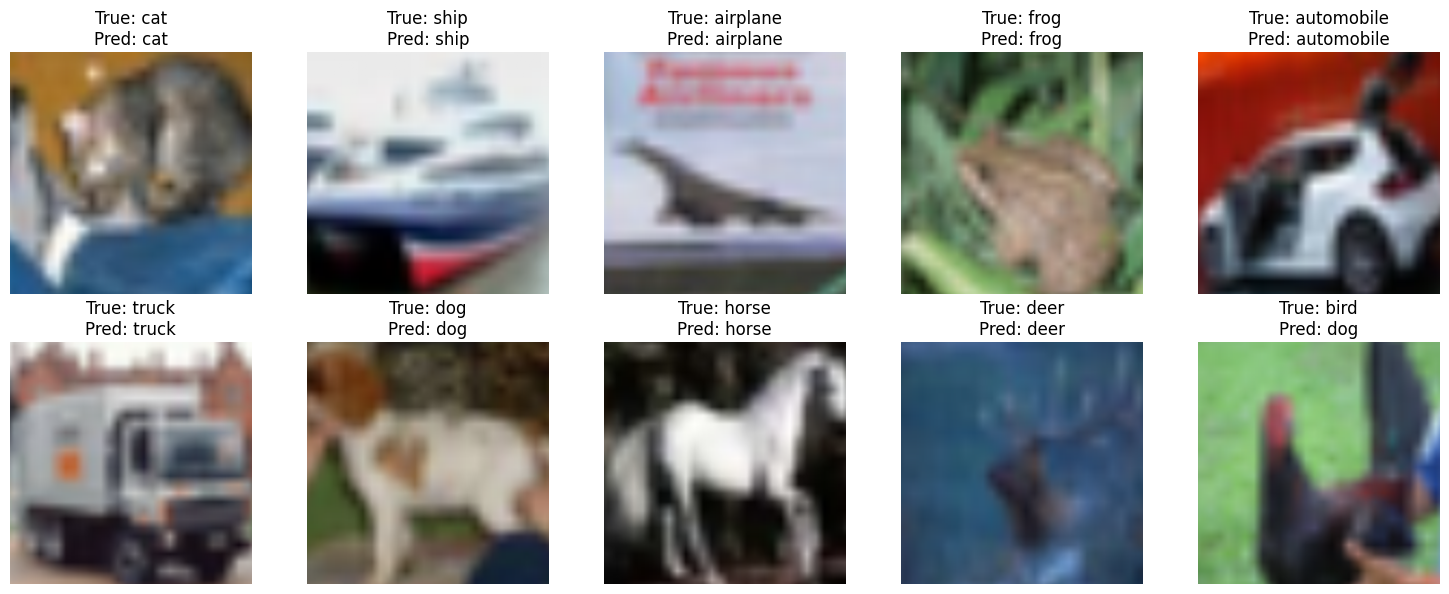

In [44]:
def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
    
    accuracy = running_corrects.double() / len(dataloader.dataset)
    return accuracy.item()

# Evaluate on test set
test_accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Save the model
torch.save(model.state_dict(), 'resnet18_cifar10_transfer_learning.pth')
print("Model saved successfully!")

# Visualize predictions on one image per class
model.eval()
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

# Find one image per class
class_indices = {}
for idx, (img, label) in enumerate(test_dataset):
    if label not in class_indices:
        class_indices[label] = idx
    if len(class_indices) == 10:
        break

for i, (class_idx, img_idx) in enumerate(class_indices.items()):
    img, true_label = test_dataset[img_idx]
    img_tensor = img.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img_tensor)
        _, pred_label = torch.max(output, 1)
        pred_label = pred_label.item()
    
    # Denormalize for display
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = torch.clamp(img, 0, 1)
    
    axes[i].imshow(img.permute(1, 2, 0).cpu().numpy())
    axes[i].set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()